In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.simplefilter(action = 'ignore')

In [144]:
amzn = pd.read_csv("dataset/AMZN_2006-01-01_to_2018-01-01.csv")
googl = pd.read_csv("dataset/GOOGL_2006-01-01_to_2018-01-01.csv")
ibm = pd.read_csv("dataset/IBM_2006-01-01_to_2018-01-01.csv")
msft = pd.read_csv("dataset/MSFT_2006-01-01_to_2018-01-01.csv")
aapl = pd.read_csv("dataset/AAPL_2006-01-01_to_2018-01-01.csv")
intc = pd.read_csv("dataset/INTC_2006-01-01_to_2018-01-01.csv")
vz = pd.read_csv("dataset/VZ_2006-01-01_to_2018-01-01.csv")
amd = pd.read_csv("dataset/AMD.csv")
nvda = pd.read_csv("dataset/nvidia_all_time_daily_stock_prices.csv")
aaba = pd.read_csv("dataset/AABA_2006-01-01_to_2018-01-01.csv")

In [145]:
amd['Date'] = pd.to_datetime(amd['Date'])
nvda['Date'] = pd.to_datetime(nvda['Date'])
start_date = pd.to_datetime('2006-01-03')
end_date = pd.to_datetime('2017-12-29')
amd_crop = amd[(amd['Date'] >= start_date) & (amd['Date'] <= end_date)]
amd_crop = amd_crop.reset_index(drop=True)
amd_crop['Close'] = amd_crop['Close'].round(2)
nvda_crop = nvda[(nvda['Date'] >= start_date) & (nvda['Date'] <= end_date)]
nvda_crop = nvda_crop.reset_index(drop = True)
nvda_crop['Close'] = nvda_crop['Close'].round(2)

In [146]:
data = pd.concat([amzn[['Date','Close']], googl["Close"], msft["Close"], aapl["Close"], intc['Close'], 
                  nvda_crop['Close'], ibm["Close"], vz['Close'], aaba['Close']], axis = 1)
data.columns = ['Date', 'amzn', 'googl', 'msft', 'aapl', 'intc','nvda', 'ibm', 'vz', 'aaba']
data['Date'] = pd.to_datetime(data['Date'])
data = data.drop(data.index[-1])
data.set_index('Date', inplace=True)
data.index.to_period('D')
print(isinstance(data.index, pd.DatetimeIndex))

True


In [147]:
data.head(5)

,amzn,googl,msft,aapl,intc,nvda,ibm,vz,aaba
Date,,,,,,,,,
2006-01-03,47.58,217.83,26.84,10.68,25.57,3.18,82.06,30.38,40.91
2006-01-04,47.25,222.84,26.97,10.71,25.91,3.27,81.95,31.27,40.97
2006-01-05,47.65,225.85,26.99,10.63,26.27,3.35,82.50,31.63,41.53
2006-01-06,47.87,233.06,26.91,10.90,26.31,3.40,84.95,31.35,43.21
2006-01-09,47.08,233.68,26.86,10.86,26.47,3.50,83.73,31.48,43.42


In [148]:
NaN_count = data.isnull().sum()
NaN_count

amzn     0
googl    0
msft     0
aapl     0
intc     0
nvda     0
ibm      0
vz       0
aaba     0
dtype: int64

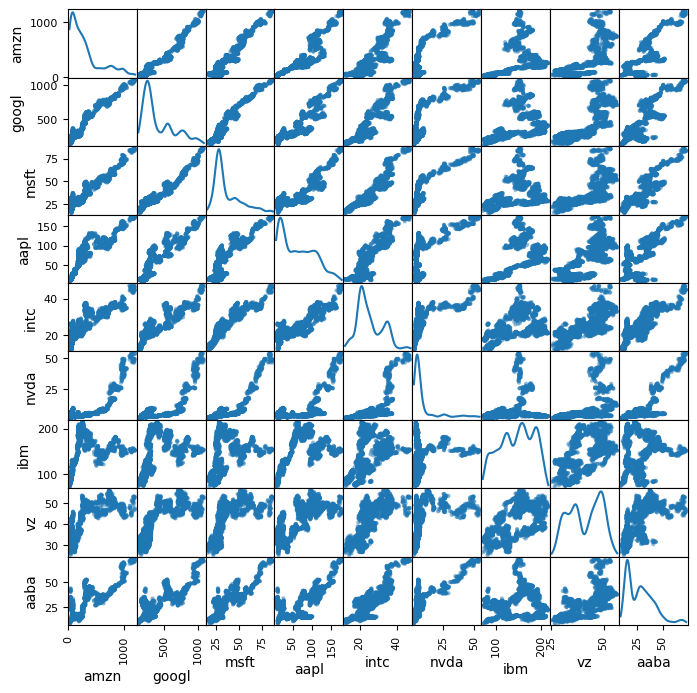

In [149]:
pd.plotting.scatter_matrix(data, figsize = (8,8), diagonal = 'kde')
plt.show()

In [150]:
def adfullertest(data, column_name, difference_order=0):
    if difference_order > 0:
        differenced_data = data[column_name].diff(difference_order).dropna()
        result = adfuller(differenced_data)
        print(f'ADF Statistic for {column_name} (Differencing Order {difference_order}): {result[0]}')
        print(f'p-value for {column_name} (Differencing Order {difference_order}): {result[1]}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print('Is Stationary:', result[1] < 0.05)
    else:
        result = adfuller(data[column_name])
        print(f'ADF Statistic for {column_name}: {result[0]}')
        print(f'p-value for {column_name}: {result[1]}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print('Is Stationary:', result[1] < 0.05)

    
#ssuming 'data' is your DataFrame with a datetime index and multiple variables
for column in data.columns:
    adfullertest(data,column)


ADF Statistic for amzn: 2.9638082255195877
p-value for amzn: 1.0
Critical Values:
   1%: -3.4325396703967974
   5%: -2.862507454335551
   10%: -2.5672850015989264
Is Stationary: False
ADF Statistic for googl: 1.3224241360302167
p-value for googl: 0.9967315857800989
Critical Values:
   1%: -3.4325396703967974
   5%: -2.862507454335551
   10%: -2.5672850015989264
Is Stationary: False
ADF Statistic for msft: 2.1707913697890535
p-value for msft: 0.9988575993461946
Critical Values:
   1%: -3.4325265517435293
   5%: -2.8625016602846984
   10%: -2.567281916911753
Is Stationary: False
ADF Statistic for aapl: 0.552367204190558
p-value for aapl: 0.9863807814299046
Critical Values:
   1%: -3.4325345499510043
   5%: -2.8625051928165557
   10%: -2.5672837975912697
Is Stationary: False
ADF Statistic for intc: -0.1282667375765534
p-value for intc: 0.9465492557585924
Critical Values:
   1%: -3.4325294533972204
   5%: -2.862502941845959
   10%: -2.567282599200112
Is Stationary: False
ADF Statistic for 

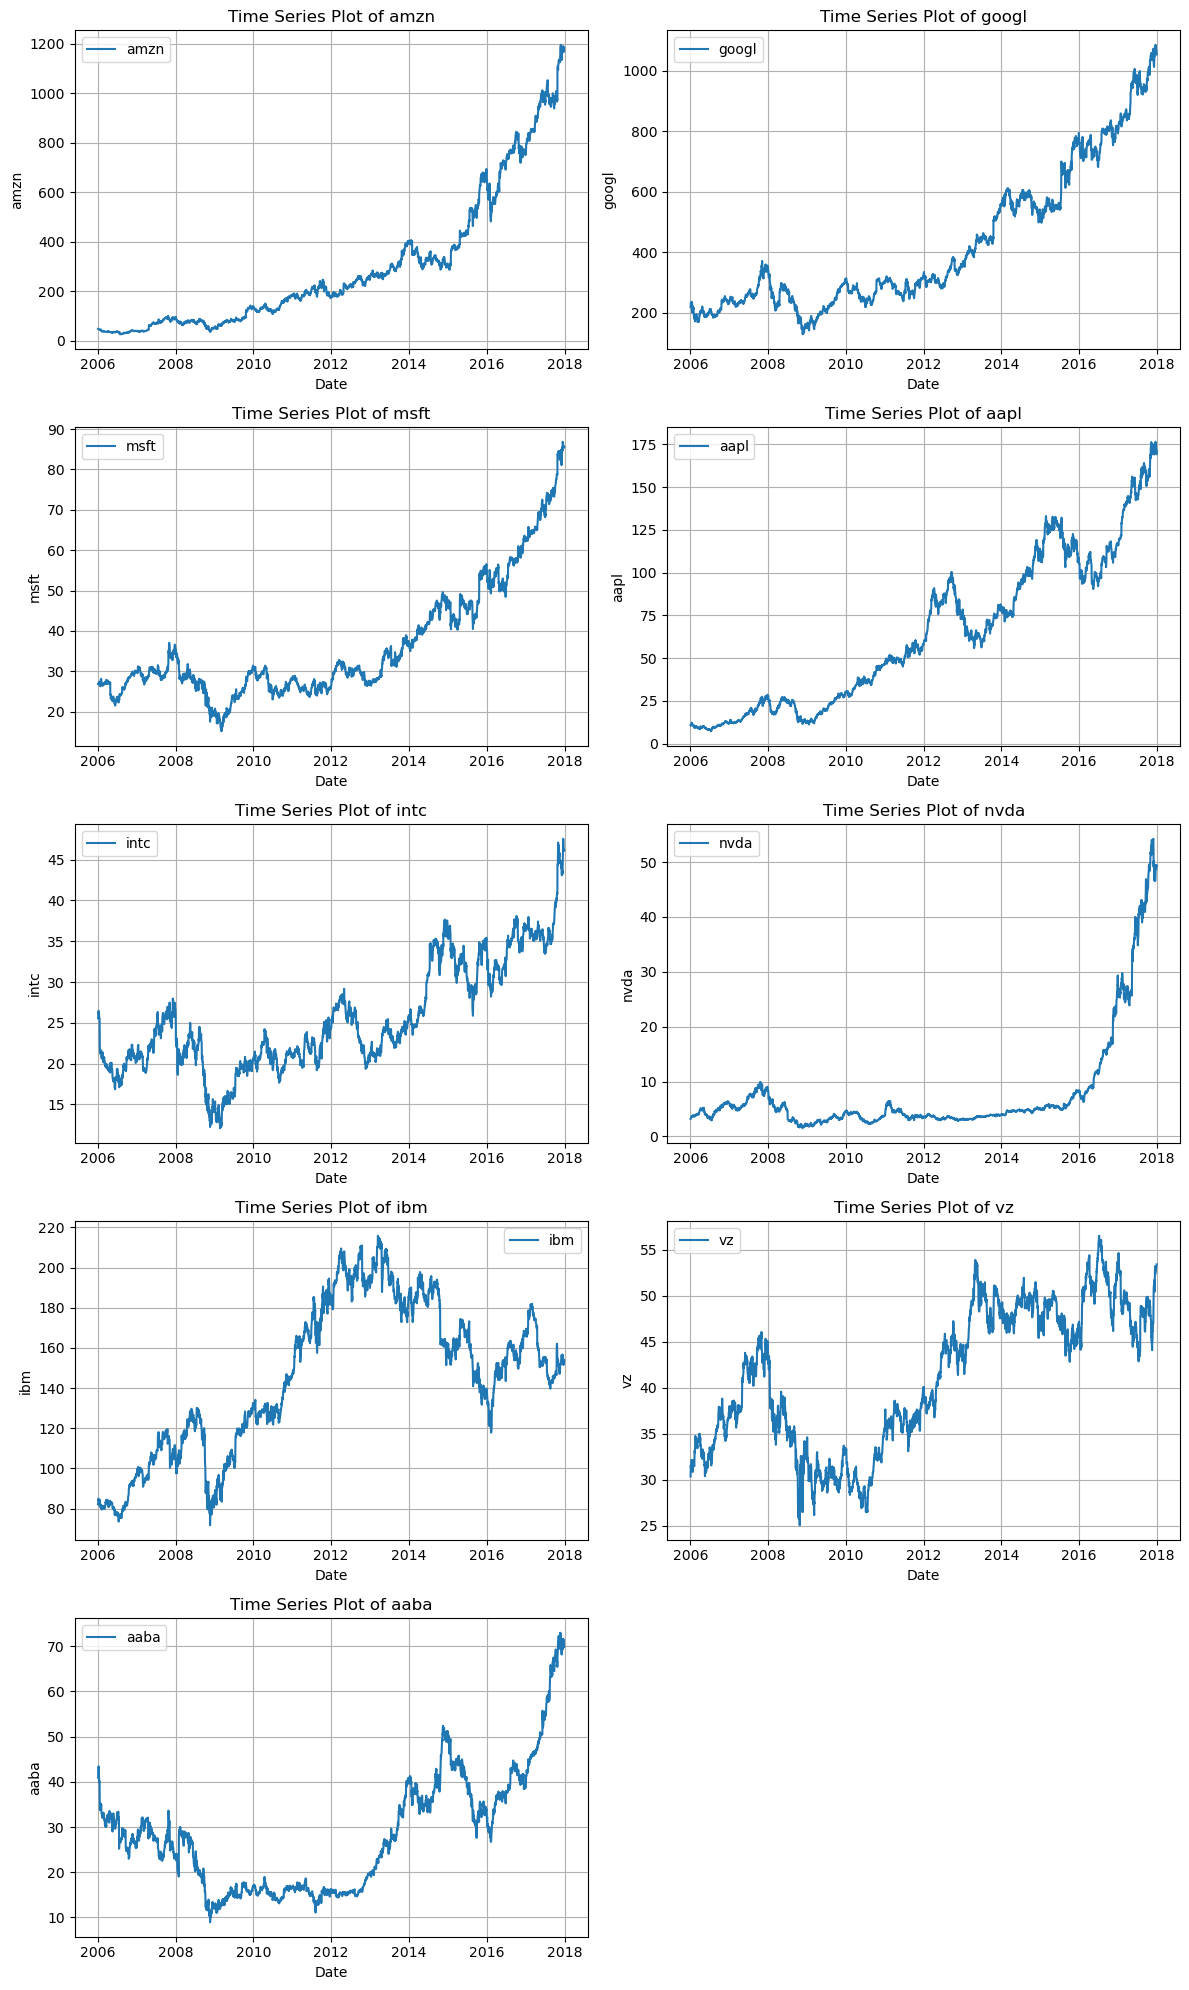

In [151]:
variables_to_plot = data.columns

num_variables = len(variables_to_plot)
num_rows = (num_variables + 1) // 2  
num_cols = 2 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Flatten the axes array if it's not already flat
if num_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for i, variable in enumerate(variables_to_plot):
    row = i // num_cols
    col = i % num_cols

    axes[i].plot(data.index, data[variable], label=variable)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(variable)
    axes[i].set_title('Time Series Plot of ' + variable)
    axes[i].legend()
    axes[i].grid(True)

# Hide any unused subplots
for j in range(num_variables, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [152]:
stationary = data.copy()

In [153]:
adfuller_amzn = adfullertest(stationary, 'amzn', 1)
adfuller_googl = adfullertest(stationary, 'googl', 1)
adfuller_msft = adfullertest(stationary, 'msft', 1)
adfuller_aapl = adfullertest(stationary, 'aapl', 1)
adfuller_intc = adfullertest(stationary, 'intc', 1)
adfuller_nvda = adfullertest(stationary, 'nvda', 1)
adfuller_ibm = adfullertest(stationary, 'ibm', 1)
adfuller_vz = adfullertest(stationary, 'vz', 1)
adfuller_aaba = adfullertest(stationary, 'aaba', 1)

adfuller_amzn
adfuller_googl
adfuller_msft
adfuller_aapl
adfuller_intc
adfuller_nvda
adfuller_ibm
adfuller_vz
adfuller_aaba

ADF Statistic for amzn (Differencing Order 1): -10.094753795777912
p-value for amzn (Differencing Order 1): 1.0983139936571981e-17
Critical Values:
   1%: -3.4325396703967974
   5%: -2.862507454335551
   10%: -2.5672850015989264
Is Stationary: True
ADF Statistic for googl (Differencing Order 1): -10.715538736001102
p-value for googl (Differencing Order 1): 3.2487316502660533e-19
Critical Values:
   1%: -3.432540403849221
   5%: -2.862507778275112
   10%: -2.5672851740608125
Is Stationary: True
ADF Statistic for msft (Differencing Order 1): -17.15856610624812
p-value for msft (Differencing Order 1): 6.866235433795143e-30
Critical Values:
   1%: -3.4325265517435293
   5%: -2.8625016602846984
   10%: -2.567281916911753
Is Stationary: True
ADF Statistic for aapl (Differencing Order 1): -11.195686633549675
p-value for aapl (Differencing Order 1): 2.3096464854099648e-20
Critical Values:
   1%: -3.4325345499510043
   5%: -2.8625051928165557
   10%: -2.5672837975912697
Is Stationary: True
ADF 

In [154]:
#ganger1 = grangercausalitytests(stationary[['amzn', 'googl']], 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0375  , p=0.8465  , df_denom=3015, df_num=1
ssr based chi2 test:   chi2=0.0375  , p=0.8464  , df=1
likelihood ratio test: chi2=0.0375  , p=0.8464  , df=1
parameter F test:         F=0.0375  , p=0.8465  , df_denom=3015, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3517  , p=0.7035  , df_denom=3012, df_num=2
ssr based chi2 test:   chi2=0.7045  , p=0.7031  , df=2
likelihood ratio test: chi2=0.7044  , p=0.7031  , df=2
parameter F test:         F=0.3517  , p=0.7035  , df_denom=3012, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3665  , p=0.0690  , df_denom=3009, df_num=3
ssr based chi2 test:   chi2=7.1160  , p=0.0683  , df=3
likelihood ratio test: chi2=7.1076  , p=0.0685  , df=3
parameter F test:         F=2.3665  , p=0.0690  , df_denom=3009, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8345  , p=0.

In [155]:
#ganger1 = grangercausalitytests(stationary[['googl', 'amzn']], 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2630  , p=0.0071  , df_denom=3015, df_num=1
ssr based chi2 test:   chi2=7.2702  , p=0.0070  , df=1
likelihood ratio test: chi2=7.2614  , p=0.0070  , df=1
parameter F test:         F=7.2630  , p=0.0071  , df_denom=3015, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9426  , p=0.0195  , df_denom=3012, df_num=2
ssr based chi2 test:   chi2=7.8982  , p=0.0193  , df=2
likelihood ratio test: chi2=7.8879  , p=0.0194  , df=2
parameter F test:         F=3.9426  , p=0.0195  , df_denom=3012, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4205  , p=0.0166  , df_denom=3009, df_num=3
ssr based chi2 test:   chi2=10.2854 , p=0.0163  , df=3
likelihood ratio test: chi2=10.2679 , p=0.0164  , df=3
parameter F test:         F=3.4205  , p=0.0166  , df_denom=3009, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5787  , p=0.

In [156]:
#Testing for amzn and googl
#amzn_googl_data = stationary[['amzn', 'googl']]

train_df.shape

(2919, 9)

In [102]:
diff_order = 1
#data_diff = stationary.copy()
#data_diff = data_diff.diff(diff_order).dropna()
#data_diff.head(5)

In [157]:
train_df = stationary[:-100]
test_df = stationary[-100:]
train_df.shape
model = VAR(train_df)
sorted_order = model.select_order(maxlags = 20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        42.19       42.21   2.105e+18       42.20
1      -0.7653     -0.5799      0.4652     -0.6985
2     -0.9916*    -0.6393*     0.3710*    -0.8647*
3      -0.9844     -0.4653      0.3737     -0.7973
4      -0.9794     -0.2934      0.3756     -0.7322
5      -0.9599     -0.1070      0.3830     -0.6526
6      -0.9472     0.07254      0.3878     -0.5798
7      -0.9220      0.2646      0.3977     -0.4945
8      -0.9076      0.4459      0.4035     -0.4199
9      -0.8888      0.6315      0.4112     -0.3410
10     -0.8658      0.8214      0.4208     -0.2579
11     -0.8487       1.005      0.4281     -0.1807
12     -0.8430       1.178      0.4305     -0.1148
13     -0.8195       1.368      0.4408    -0.03120
14     -0.7912       1.563      0.4535     0.05719
15     -0.7769       1.745      0.4601      0.1317
16     -0.7738       1.915     

In [158]:
var_model = VARMAX(train_df, order = (2,0), enforce_stationarity = True)
fitted_model = var_model.fit(disp = False)
print(fitted_model.summary())

                                                     Statespace Model Results                                                     
Dep. Variable:     ['amzn', 'googl', 'msft', 'aapl', 'intc', 'nvda', 'ibm', 'vz', 'aaba']   No. Observations:                 2919
Model:                                                                             VAR(2)   Log Likelihood             -107686.671
                                                                              + intercept   AIC                         215805.343
Date:                                                                    Tue, 05 Dec 2023   BIC                         217096.806
Time:                                                                            11:31:52   HQIC                        216270.526
Sample:                                                                                 0                                         
                                                                                   

In [159]:
n_forecast = 10
predict = fitted_model.get_prediction(start = len(train_df), end = len(train_df) + n_forecast - 1)
predictions = predict.predicted_mean

In [162]:
predictions.columns =  ['amzn_predicted', 'googl_predicted', 'msft_predicted', 'aapl_predicted', 'intc_predicted', 'nvda_predicted', 'ibm_predicted', 'vz_predicted', 'aaba_predicted']
predictions

,amzn_predicted,googl_predicted,msft_predicted,aapl_predicted,intc_predicted,nvda_predicted,ibm_predicted,vz_predicted,aaba_predicted
2919,1006.089507,979.633519,72.673174,164.489194,38.824263,36.370121,155.879516,54.006777,67.151390
2920,999.165833,976.965900,73.044753,166.051746,39.558272,36.025425,157.666449,54.961705,67.351528
2921,1008.356535,997.249886,72.375942,169.128030,40.635501,31.393386,164.683866,57.606286,72.128262
2922,1000.734179,994.428549,71.761439,171.563363,40.919196,29.718602,167.348703,57.812947,72.064556
2923,1011.381662,1014.870381,71.778232,175.207236,41.901548,26.463167,174.671632,59.980778,75.679674
2924,1003.883898,1014.565350,71.394978,178.041742,42.366578,24.375083,179.044553,60.589041,75.902408
2925,1012.737893,1031.177705,71.594999,181.578165,43.203351,21.843221,185.756784,62.152918,78.445557
2926,1004.309399,1030.303034,71.051457,184.353878,43.519106,19.477597,190.062991,62.552149,78.604673
2927,1011.828209,1044.131487,71.254198,187.925514,44.216016,17.255111,196.445948,63.571177,80.299068
2928,1003.636368,1044.052274,70.798102,190.674480,44.512896,14.831229,200.902420,63.944227,80.455818


In [163]:
test_df.head(10)

,amzn,googl,msft,aapl,intc,nvda,ibm,vz,aaba
Date,,,,,,,,,
2017-08-09,982.01,940.08,72.47,161.06,36.59,42.58,142.11,48.60,59.77
2017-08-10,956.92,923.59,71.41,155.32,36.14,43.03,141.77,48.22,58.03
2017-08-11,967.99,930.09,72.50,157.48,35.87,41.19,141.84,48.02,57.92
2017-08-14,983.30,938.93,73.59,159.85,36.34,38.99,141.84,48.06,58.87
2017-08-15,982.74,938.08,73.22,161.60,36.00,42.10,142.32,48.78,59.99
2017-08-16,978.18,944.27,73.65,160.95,35.81,41.74,142.07,48.48,60.65
2017-08-17,960.57,927.66,72.40,157.86,35.17,41.29,142.50,48.41,62.20
2017-08-18,958.47,926.18,72.49,157.50,35.01,40.37,140.70,47.89,63.07
2017-08-21,953.29,920.87,72.15,157.21,34.92,40.38,139.70,47.69,63.60


<Axes: >

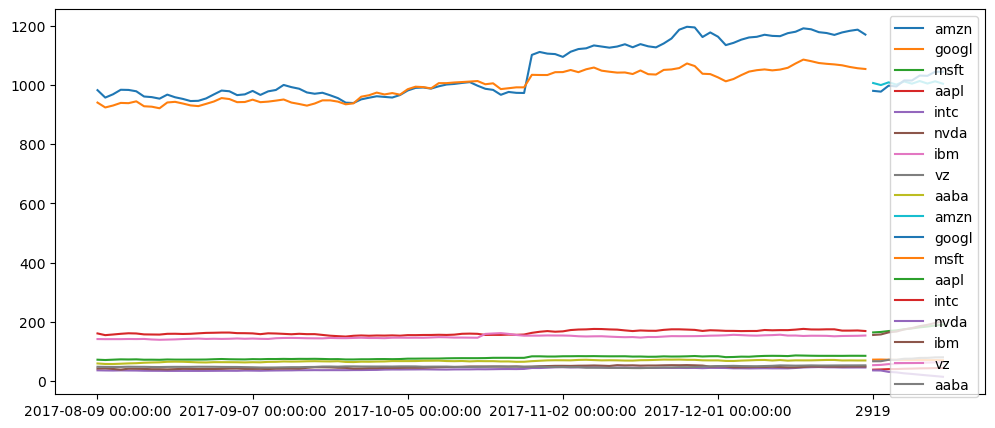

In [130]:
#test_vs_pred = pd.concat([test_df, predictions], axis = 1)
#test_vs_pred.plot(figsize=(12,5))

In [173]:
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

mean_amzn_10 = test_df['amzn'].head(10).mean()
rmse_amzn = math.sqrt(mean_squared_error(predictions['amzn_predicted'], test_df.iloc[1:11]['amzn']))
print('AMZN: mean is', mean_amzn_10, 'rmse is', rmse_amzn)
mean_googl_10 = test_df['googl'].head(10).mean()
rmse_googl = math.sqrt(mean_squared_error(predictions['googl_predicted'], test_df.iloc[1:11]['googl']))
print('GOOGL: mean is', mean_googl_10, 'rmse is', rmse_googl)
mean_msft_10 = test_df['msft'].head(10).mean()
rmse_msft = math.sqrt(mean_squared_error(predictions['msft_predicted'], test_df.iloc[1:11]['msft']))
print('MSFT: mean is', mean_msft_10, 'rmse is', rmse_msft)
mean_aapl_10 = test_df['aapl'].head(10).mean()
rmse_aapl = math.sqrt(mean_squared_error(predictions['aapl_predicted'], test_df.iloc[1:11]['aapl']))
print('AAPL: mean is', mean_aapl_10, 'rmse is', rmse_aapl)
mean_intc_10 = test_df['intc'].head(10).mean()
rmse_intc = math.sqrt(mean_squared_error(predictions['intc_predicted'], test_df.iloc[1:11]['intc']))
print('INTC: mean is', mean_intc_10, 'rmse is', rmse_intc)
mean_nvda_10 = test_df['nvda'].head(10).mean()
rmse_nvda = math.sqrt(mean_squared_error(predictions['nvda_predicted'], test_df.iloc[1:11]['nvda']))
print('NVDA: mean is', mean_nvda_10, 'rmse is', rmse_nvda)
mean_ibm_10 = test_df['ibm'].head(10).mean()
rmse_ibm = math.sqrt(mean_squared_error(predictions['ibm_predicted'], test_df.iloc[1:11]['ibm']))
print('IBM: mean is', mean_ibm_10, 'rmse is', rmse_ibm)
mean_vz_10 = test_df['vz'].head(10).mean()
rmse_vz = math.sqrt(mean_squared_error(predictions['vz_predicted'], test_df.iloc[1:11]['vz']))
print('VZ: mean is', mean_vz_10, 'rmse is', rmse_vz)
mean_aaba_10 = test_df['aaba'].head(10).mean()
rmse_aaba = math.sqrt(mean_squared_error(predictions['aaba_predicted'], test_df.iloc[1:11]['aaba']))
print('AABA: mean is', mean_aaba_10, 'rmse is', rmse_aaba)

AMZN: mean is 969.037 rmse is 41.19325523042357
GOOGL: mean is 933.015 rmse is 82.76986064076586
MSFT: mean is 72.704 rmse is 1.3907151110262528
AAPL: mean is 158.861 rmse is 20.01084726079801
INTC: mean is 35.65 rmse is 6.942765849537815
NVDA: mean is 41.146 rmse is 16.599988886812707
IBM: mean is 141.51799999999997 rmse is 39.113744654027634
VZ: mean is 48.229 rmse is 12.002550338365518
AABA: mean is 60.952 rmse is 13.433237840236181


In [ ]:
sns.lineplot(data = stationary.dropna(), x = stationary.Date, y = stationary.MA_amzn)

In [63]:
stationary['sqrt_amzn'] = np.log(stationary['amzn'])
adfullertest(stationary, 'sqrt_amzn')

ADF Statistic for sqrt_amzn: -0.1085225175812586
p-value for sqrt_amzn: 0.9485830136862611
Critical Values:
   1%: -3.4325200511877854
   5%: -2.862498789206885
   10%: -2.567280388383968
Is Stationary: False


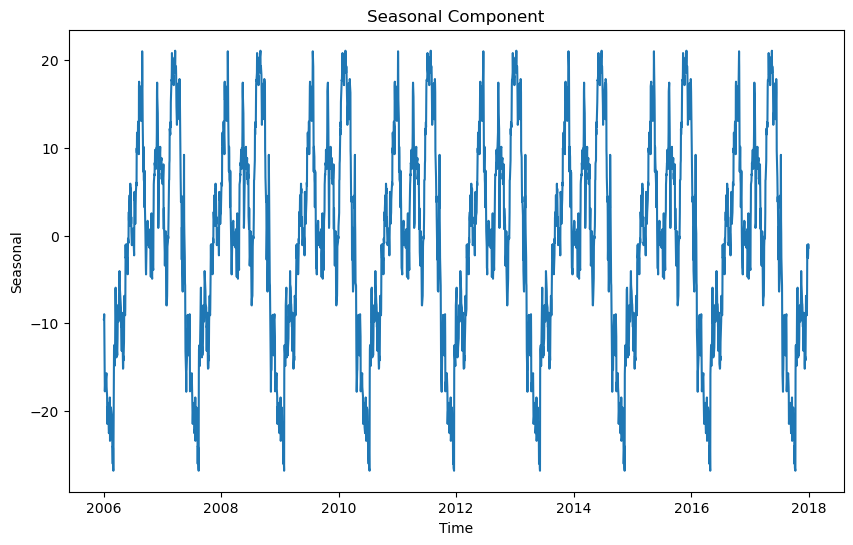

In [183]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(stationary['amzn'], model='additive', period = 365)
trend = result.trend
seasonal = result.seasonal
residual = result.resid

plt.figure(figsize=(10, 6))
plt.plot(seasonal)
plt.title('Seasonal Component')
plt.xlabel('Time')
plt.ylabel('Seasonal')
plt.show()

In [ ]:
#gar sage model
#jointly or seperately
#for ar model, vectorized model
#figure out differencing order